# Select a reasonable Training Set for Solar Twins in GALAH+ DR3

In [1]:
# Compatibility with Python 3
from __future__ import (absolute_import, division, print_function)

try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

# Basic Tools
import numpy as np
from astropy.table import Table
import corner
import matplotlib.pyplot as plt

# The Cannon
# import thecannon as tc

In [2]:
galah_elements = [
    'Li','C','O',
    'Na','Mg','Al','Si',
    'K','Ca','Sc','Ti','V','Cr','Mn','Co','Ni','Cu','Zn',
    'Rb','Sr','Y','Zr','Mo','Ru',
    'Ba','La','Ce','Nd','Sm','Eu'
]

In [3]:
data = Table.read('data/GALAH_DR3_main_allspec_v2.fits')

In [4]:
solar_twins = (
    (data['flag_sp'] == 0) &
    (np.abs(data['teff']-5777.) < 200) &
    (np.abs(data['logg']-4.44) < 0.3) &
    (np.abs(data['fe_h']-0.00) < 0.3)
)

/Users/svenbuder/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)


In [5]:
# Let's get an idea of the detection rate for each element among solar twins
for element in galah_elements:
    detected_in_solar_twins = solar_twins & (data['flag_'+element+'_fe'] == 0)
    print(element, ' Detection rate:', np.round(100*len(data['teff'][detected_in_solar_twins])/len(data['teff'][solar_twins])))

Li  Detection rate: 47.0
C  Detection rate: 45.0
O  Detection rate: 98.0
Na  Detection rate: 100.0
Mg  Detection rate: 100.0
Al  Detection rate: 98.0
Si  Detection rate: 100.0
K  Detection rate: 97.0
Ca  Detection rate: 97.0
Sc  Detection rate: 100.0
Ti  Detection rate: 97.0
V  Detection rate: 45.0
Cr  Detection rate: 100.0
Mn  Detection rate: 100.0
Co  Detection rate: 34.0
Ni  Detection rate: 94.0
Cu  Detection rate: 98.0
Zn  Detection rate: 99.0
Rb  Detection rate: 1.0
Sr  Detection rate: 2.0
Y  Detection rate: 94.0
Zr  Detection rate: 5.0
Mo  Detection rate: 1.0
Ru  Detection rate: 0.0
Ba  Detection rate: 100.0
La  Detection rate: 26.0
Ce  Detection rate: 29.0
Nd  Detection rate: 4.0
Sm  Detection rate: 8.0
Eu  Detection rate: 1.0


In [6]:
# Let's select the abundances that we want to fit.
# The longer this list, the smaller our training set
# Not at all recommended are: Rb, Sr, Zr, Mo, Ru, Nd, Sm, Eu

# The following list will go almost up to 83.5% detection rate
abundances_to_fit1 = ['O','Na','Mg','Al','Si','K','Ca','Sc','Ti','Cr','Mn','Ni','Cu','Zn','Y','Ba']

# Adding either Li, C, or V will drop it already to 40-42%
# From the diagnostic plots below if also becomes clear,
# that the uniform sampling (especially in Teff) is not ensured anymore
abundances_to_fit2 = ['Li','O','Na','Mg','Al','Si','K','Ca','Sc','Ti','Cr','Mn','Ni','Cu','Zn','Y','Ba']

# We will therefore proceed with the abundance list 1
abundances_to_fit = abundances_to_fit1

# We can further test, what limits on SNR we can apply, without compromising a uniform sampling
snr_c1_iraf_cut = 50
snr_c2_iraf_cut = 50
snr_c3_iraf_cut = 50
snr_c4_iraf_cut = 50

# SNR cuts will decrease the sample down to
# SNR >= 10: 83.3% - snr_c2_iraf > 10 was a requirement for flag_sp
# SNR >= 20: 62.8%
# SNR >= 30: 36.3%
# SNR >= 40: 19.8% - this starts to cut at the low Teff
# SNR >= 50: 10.9%

best_solar_twins = (
    solar_twins &
    # loop through all element X that we want to fit and select only those with flag_X_fe==0 for all of them
    np.all([data['flag_'+elem+'_fe'] == 0 for elem in abundances_to_fit],axis=0) &
    # It further makes sence for solar twins to neglect the worst outliers above [X/Fe] > 1 and below [X/Fe] < -1
    np.all([np.abs(data[elem+'_fe']) - 1.0 < 0 for elem in abundances_to_fit],axis=0) &
    # Lastly, let's loop over our SNR limits
    (data['snr_c1_iraf'] >= snr_c1_iraf_cut) &
    (data['snr_c2_iraf'] >= snr_c2_iraf_cut) &
    (data['snr_c3_iraf'] >= snr_c3_iraf_cut) &
    (data['snr_c4_iraf'] >= snr_c4_iraf_cut)
)
# What's left?
100*len(data['teff'][best_solar_twins])/len(data['teff'][solar_twins]),len(data['teff'][best_solar_twins])

/Users/svenbuder/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater_equal
  result = getattr(super(), op)(other)


(10.868532558095346, 5720)

In [17]:
training_set = Table()
training_set['sobject_id'] = data['sobject_id'][best_solar_twins]

parameter_labels_to_fit = ['teff','logg','fe_h','vbroad']
abundances_labels_fit = [element+'_fe' for element in abundances_to_fit]
auxiliary_labels_to_fit = [] # could be parallax, BP-RP or M_G
auxiliary_information = ['snr_c1_iraf','snr_c2_iraf','snr_c3_iraf','snr_c4_iraf','rv_galah']

labels = np.concatenate((parameter_labels_to_fit,abundances_labels_fit,auxiliary_labels_to_fit))

for label in labels:
    training_set[label] = data[label][best_solar_twins]

np.savetxt('training_sets/solar_twin_training_set_16xfe_snr50_labels',labels,fmt='%s')
    
training_set.write('training_sets/solar_twin_training_set_16xfe_snr50.fits',overwrite=True)
training_set

<Table masked=True length=5720>
   sobject_id      teff   ...          Y_fe                 Ba_fe        
                    K     ...                                            
     int64       float32  ...        float64               float64       
--------------- --------- ... --------------------- ---------------------
131216001601127 5883.5923 ...   0.02202505698561431   0.04590757369995124
131216001601163 5693.5557 ...  -0.20653544144642608  -0.01467172622680657
131216001602127  5877.373 ... 0.0027167008835237024  0.057197647094726634
131216001602163  5692.164 ...  -0.18983504297776066 -0.018322391510009695
131217001801093 5720.9595 ...  -0.06564930854056342 -0.012940807342529226
131217001801134 5817.4775 ...   0.07293717364764295  0.006911354064941477
131218001901122  5861.975 ...  -0.03243505454995117   0.06351383209228523
140111002101035 5895.6147 ...  -0.08775166294473644   0.09009702682495124
140111002101120  5870.136 ...  0.020318181277271335   0.09216220855712898
            ...       ... ...                   ...                   ...
190211003801185 5876.4395 ...  -0.10904221410158069    0.0367766189575196
190212003001283 5731.7715 ...  -0.11982295132724446  -0.06671421051025384
190223001701063  5781.956 ...  -0.16268376891371025  -0.09386054992675774
190223001701187  5889.052 ...  -0.17237085948981498   -0.0810374450683593
190224001601388   5957.46 ...  -0.08107757547138436   0.08883722305297859
190225001601020  5581.011 ...  0.008131175150103474 -0.021778507232665945
190225002101028  5969.484 ...     0.101935635276836    0.2119785118103028
190225002101052  5579.424 ...   0.10281904407600914    0.3630820083618165
190225005301197  5749.248 ...  -0.13758704323661788 -0.041935367584228445
190225005301331 5965.5605 ...  -0.15856555146333523 -0.012220306396484304

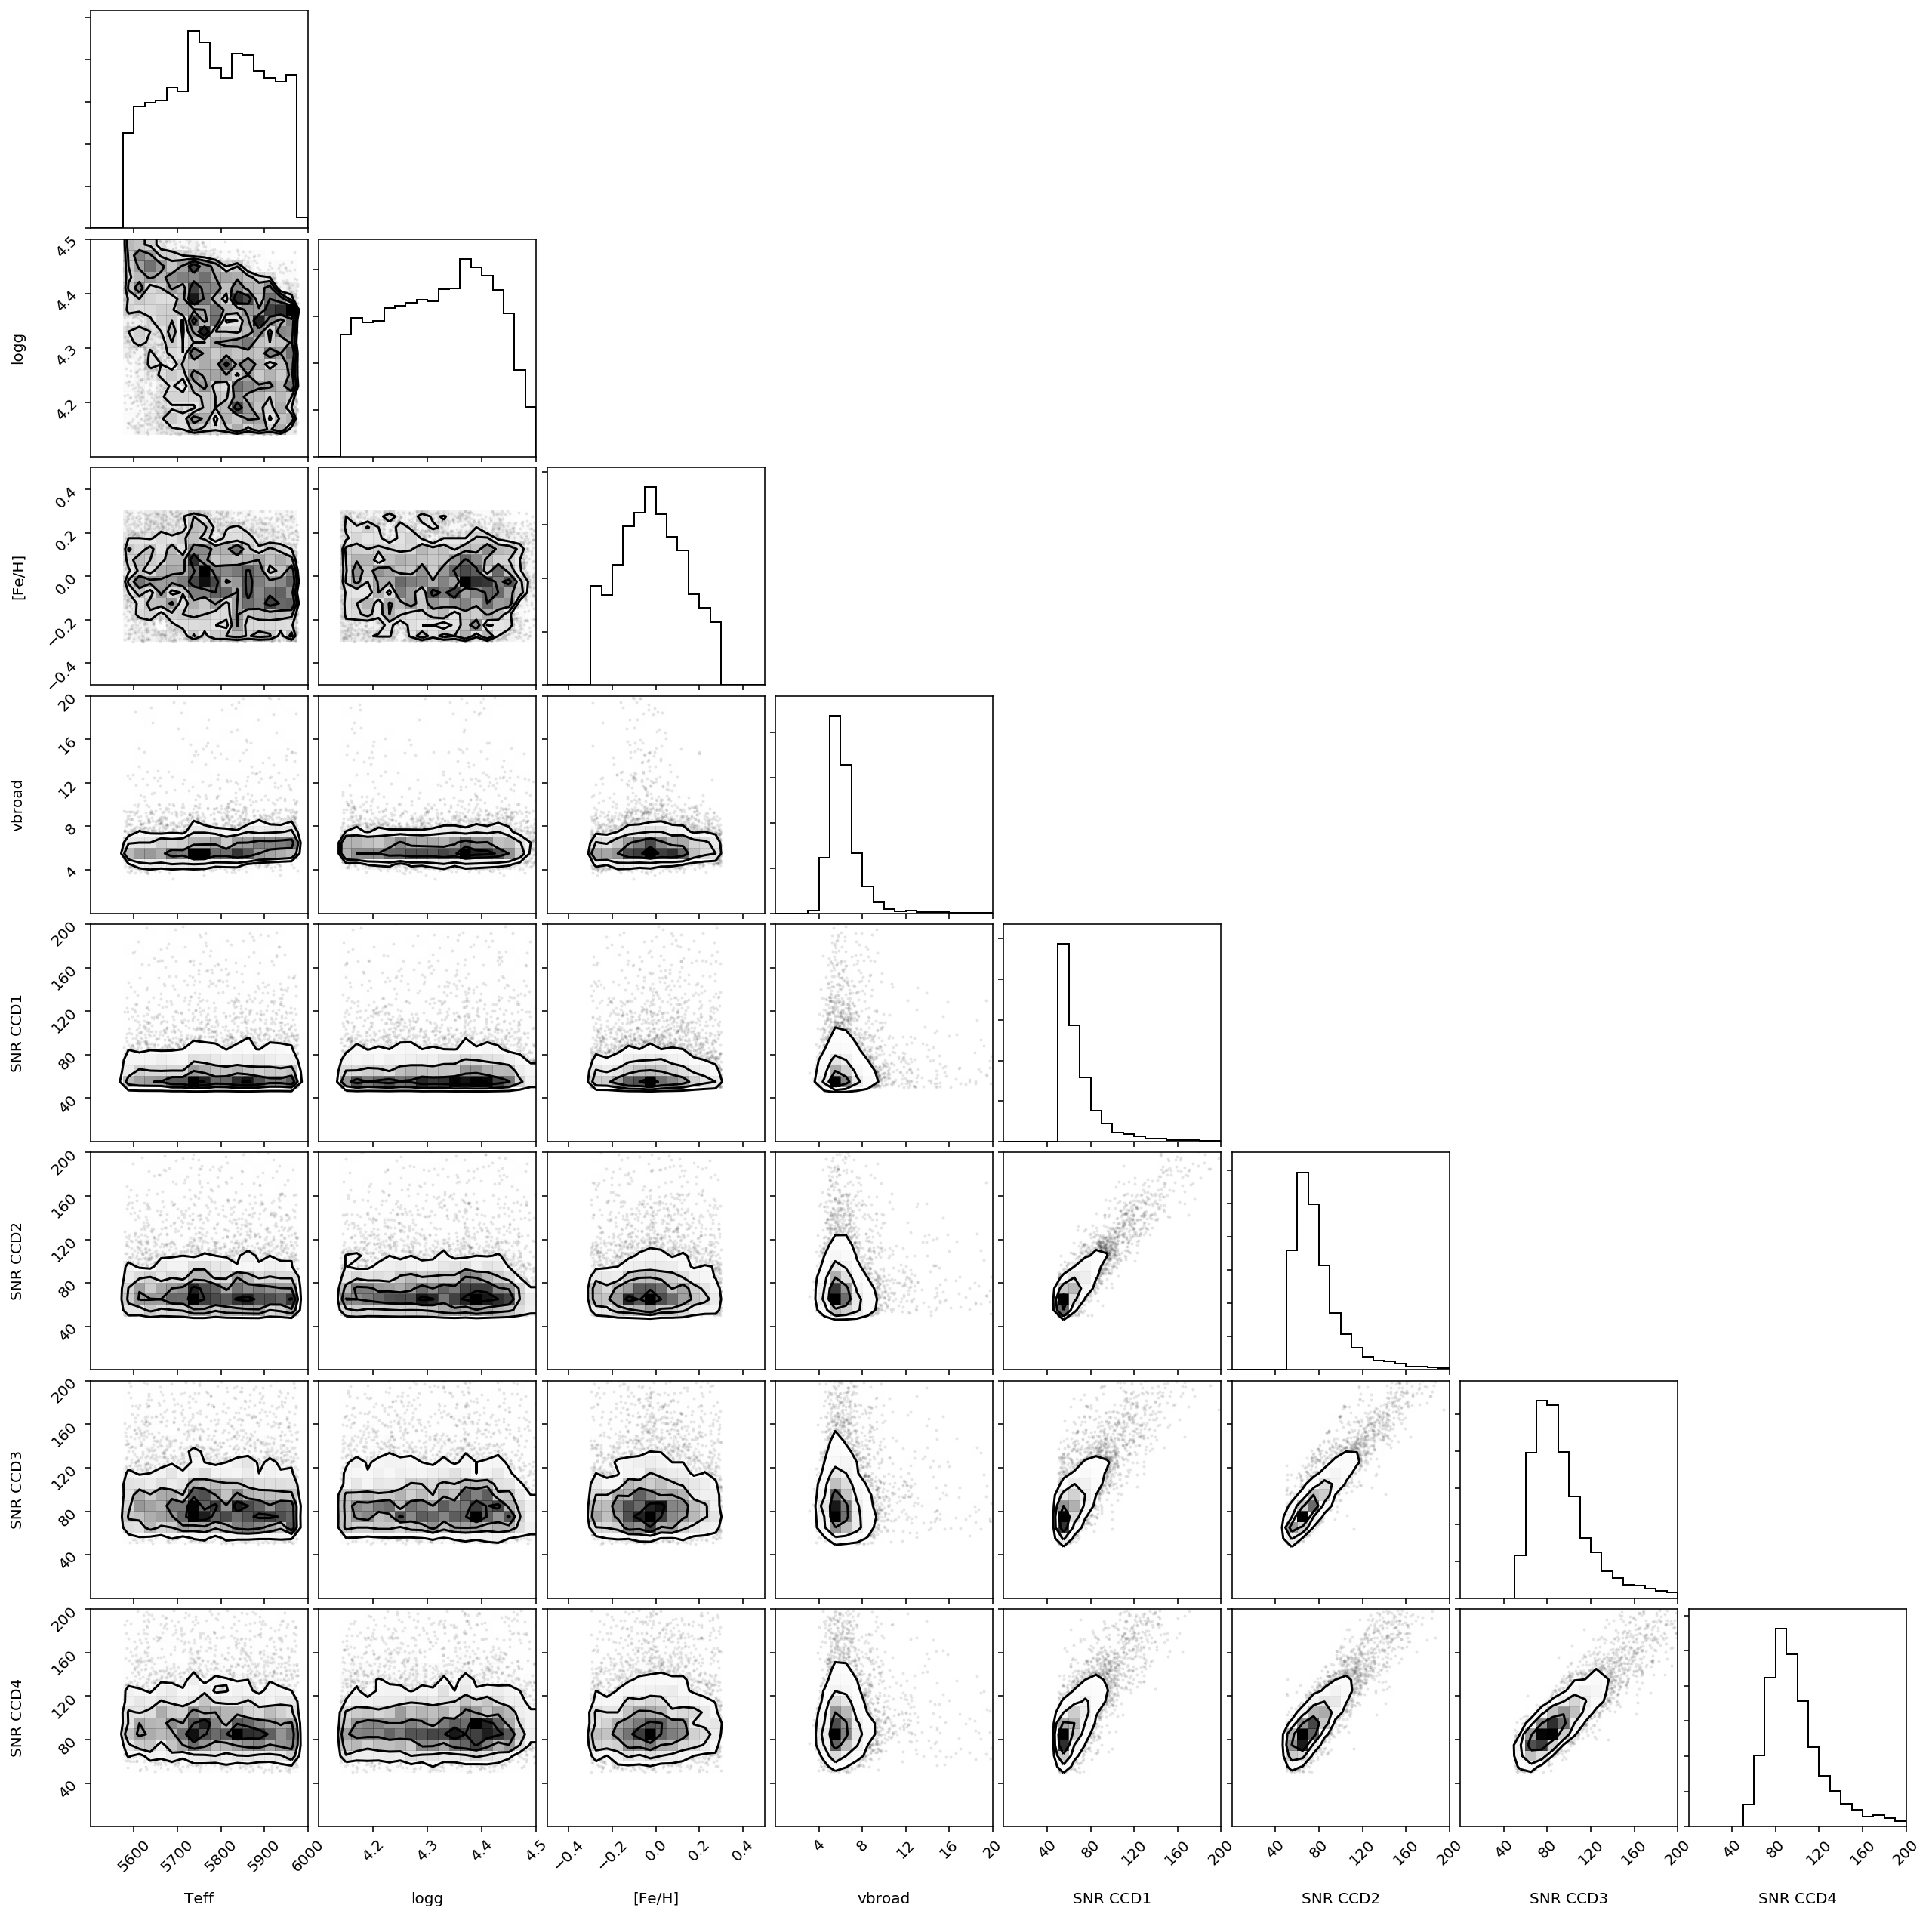

In [7]:
def diagnostic_plots_of_stellar_parameters_for_abundance_selection(best_solar_twins, abundances_to_fit):
    # First let's plot the overview of the spectroscopic quality
    corner.corner(
        np.array([
            data['teff'][best_solar_twins],
            data['logg'][best_solar_twins],
            data['fe_h'][best_solar_twins],
            data['vbroad'][best_solar_twins],
            data['snr_c1_iraf'][best_solar_twins],
            data['snr_c2_iraf'][best_solar_twins],
            data['snr_c3_iraf'][best_solar_twins],
            data['snr_c4_iraf'][best_solar_twins]
        ]).T,
        labels=['Teff','logg','[Fe/H]','vbroad','SNR CCD1','SNR CCD2','SNR CCD3','SNR CCD4'],
        range=[(5500,6000),(4.1,4.5),(-0.5,0.5),(0,20),(0,200),(0,200),(0,200),(0,200)]
    )
diagnostic_plots_of_stellar_parameters_for_abundance_selection(best_solar_twins, abundances_to_fit)

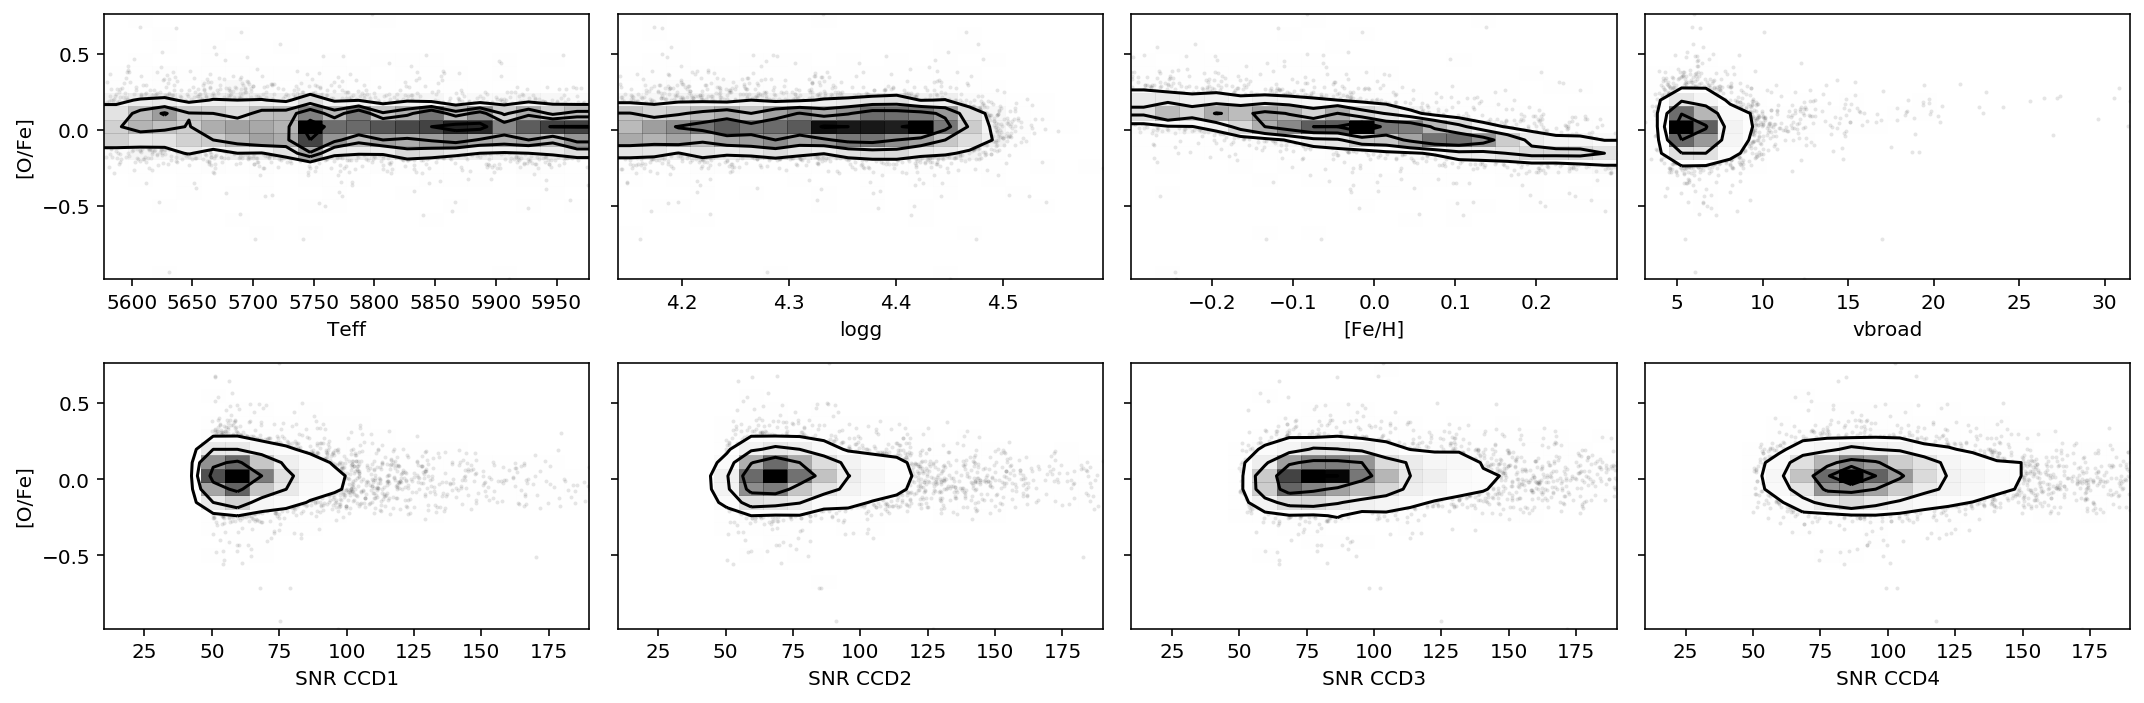

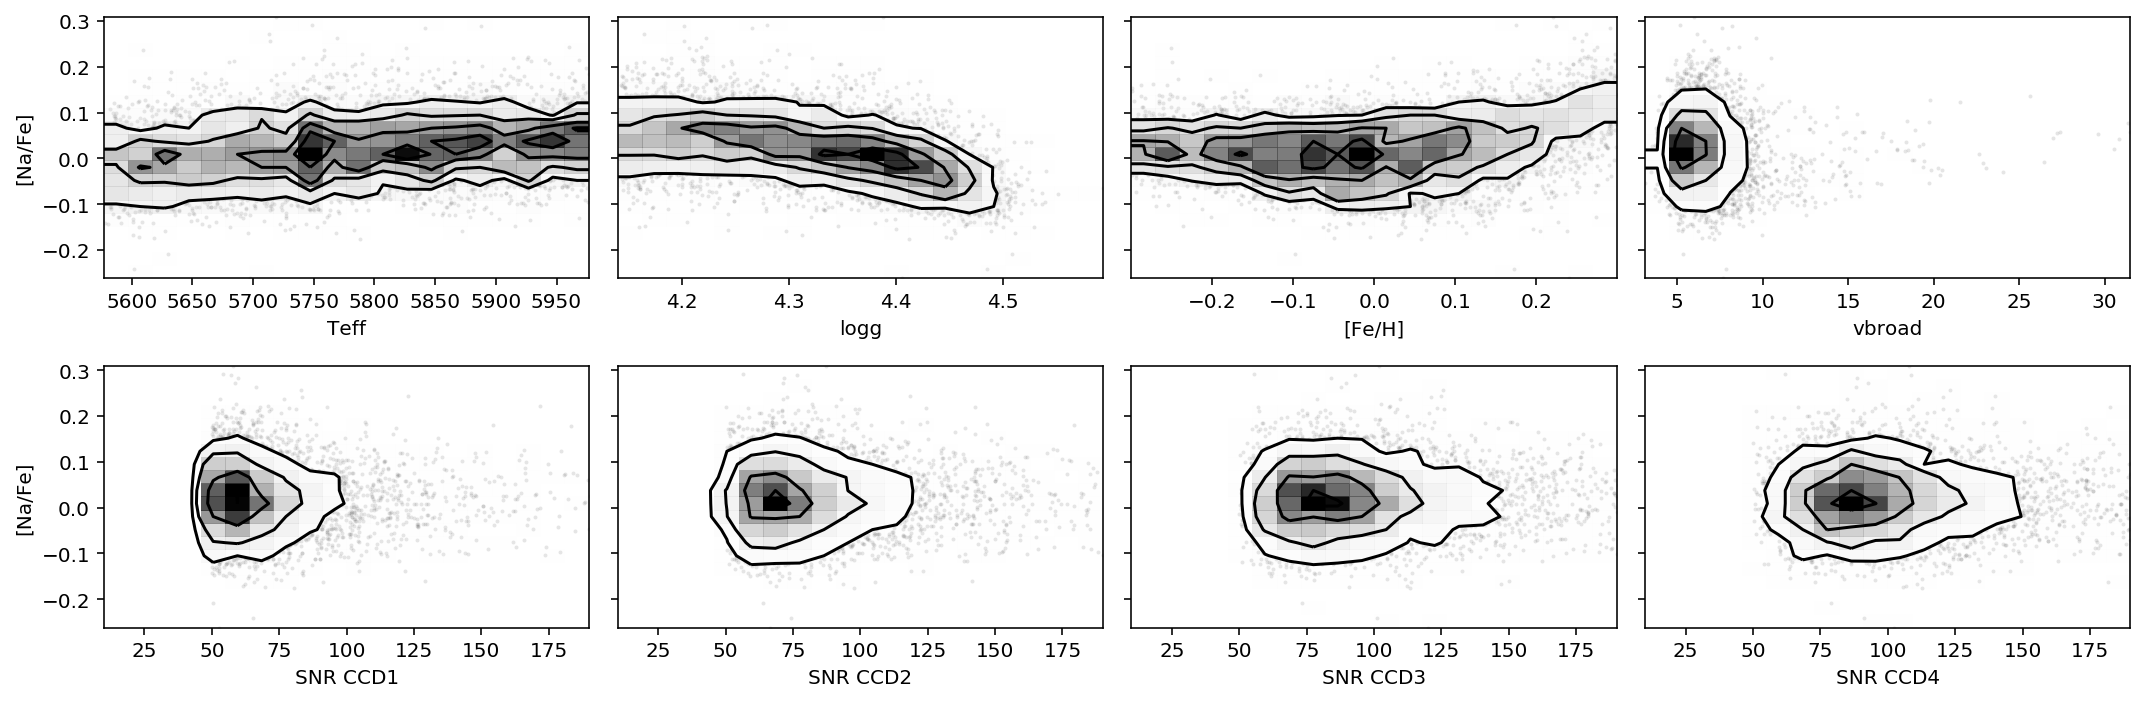

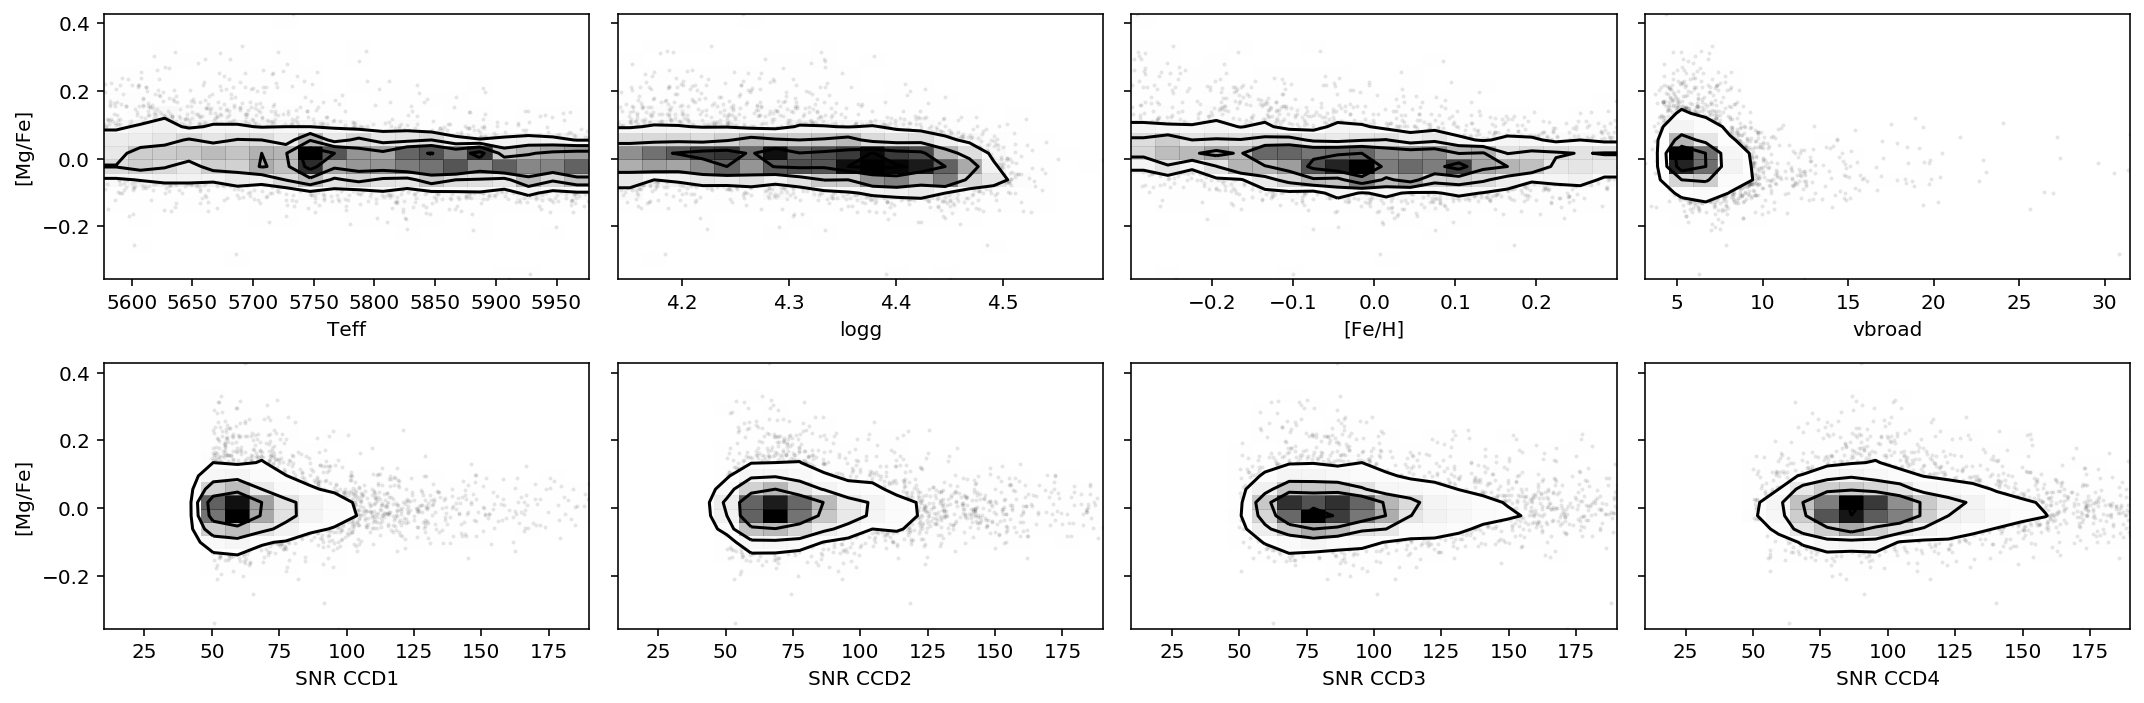

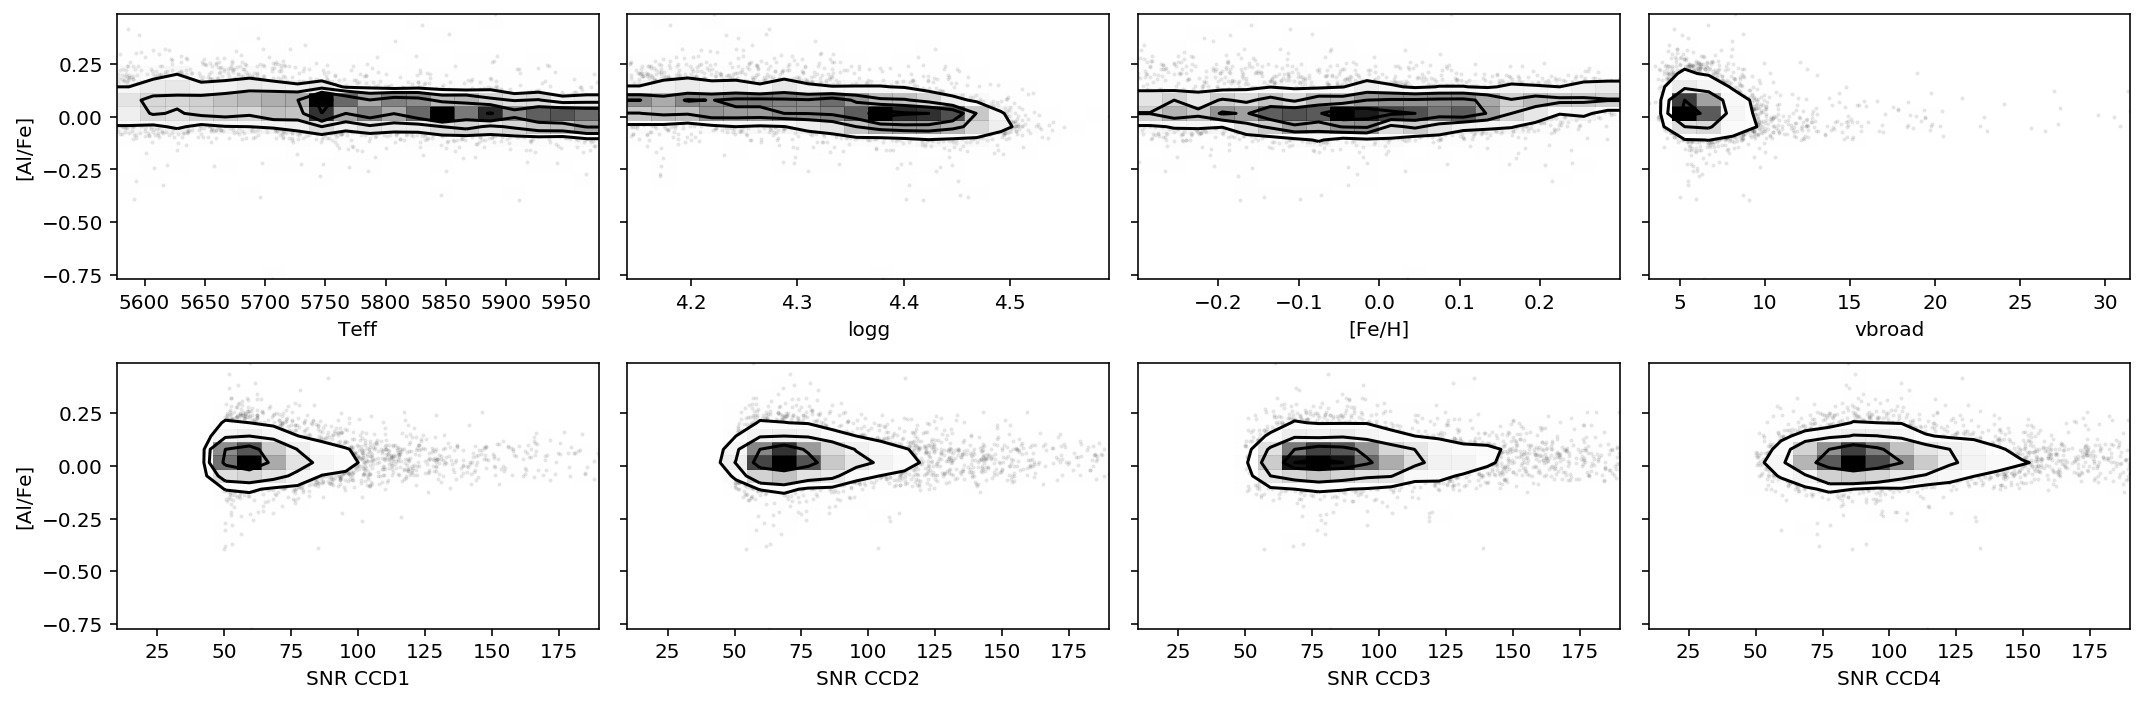

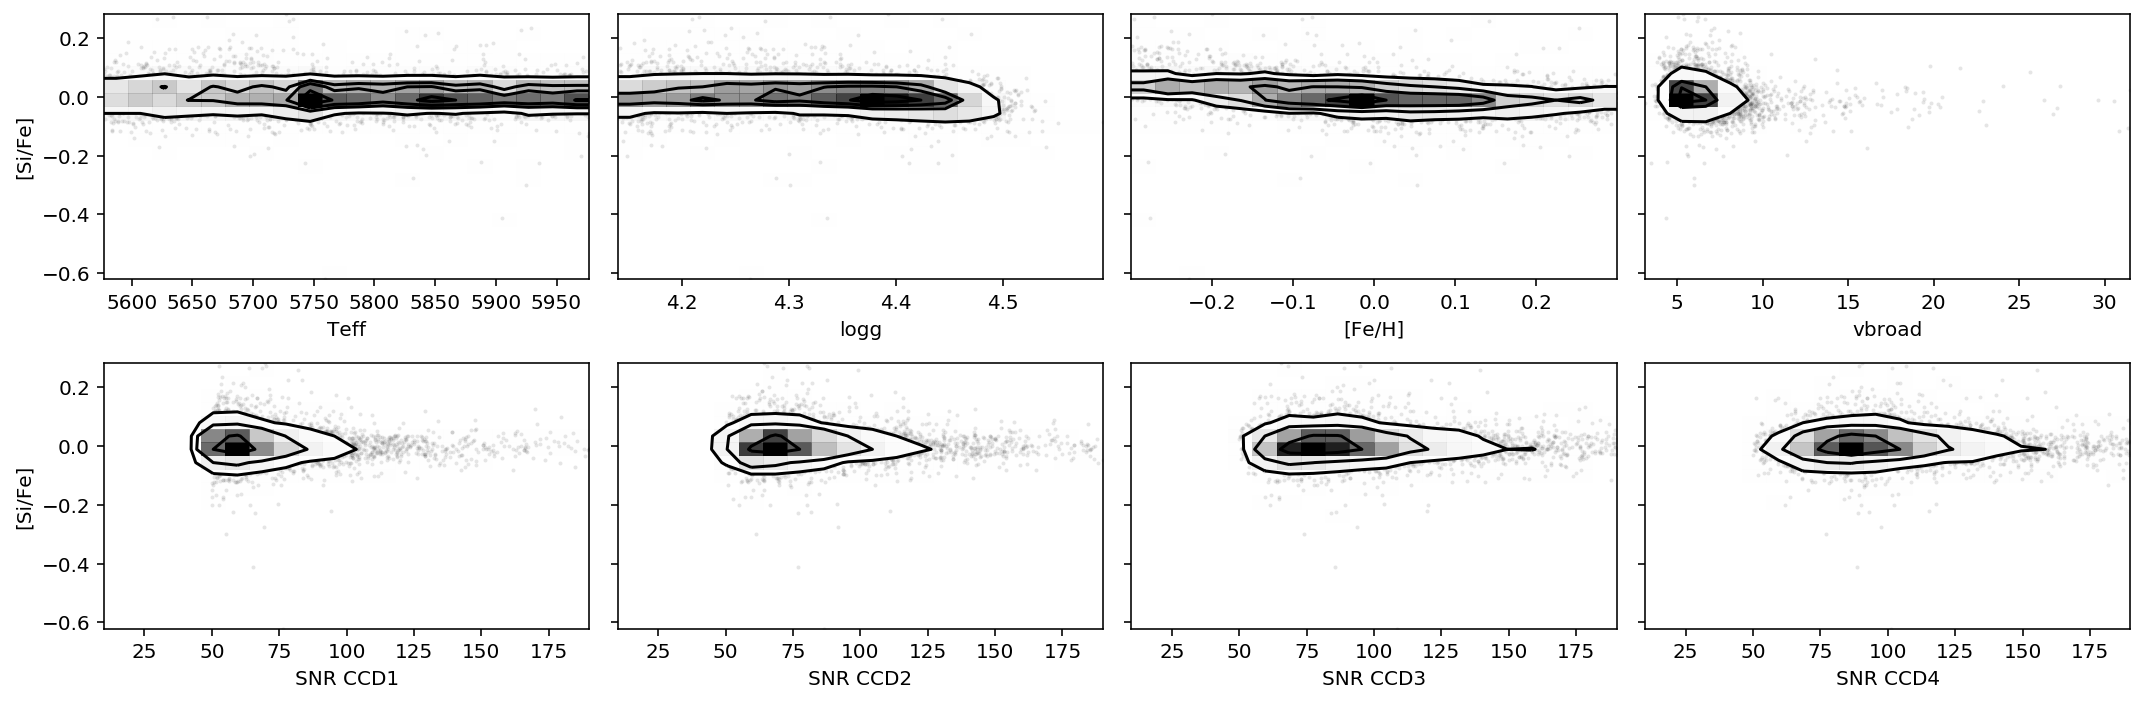

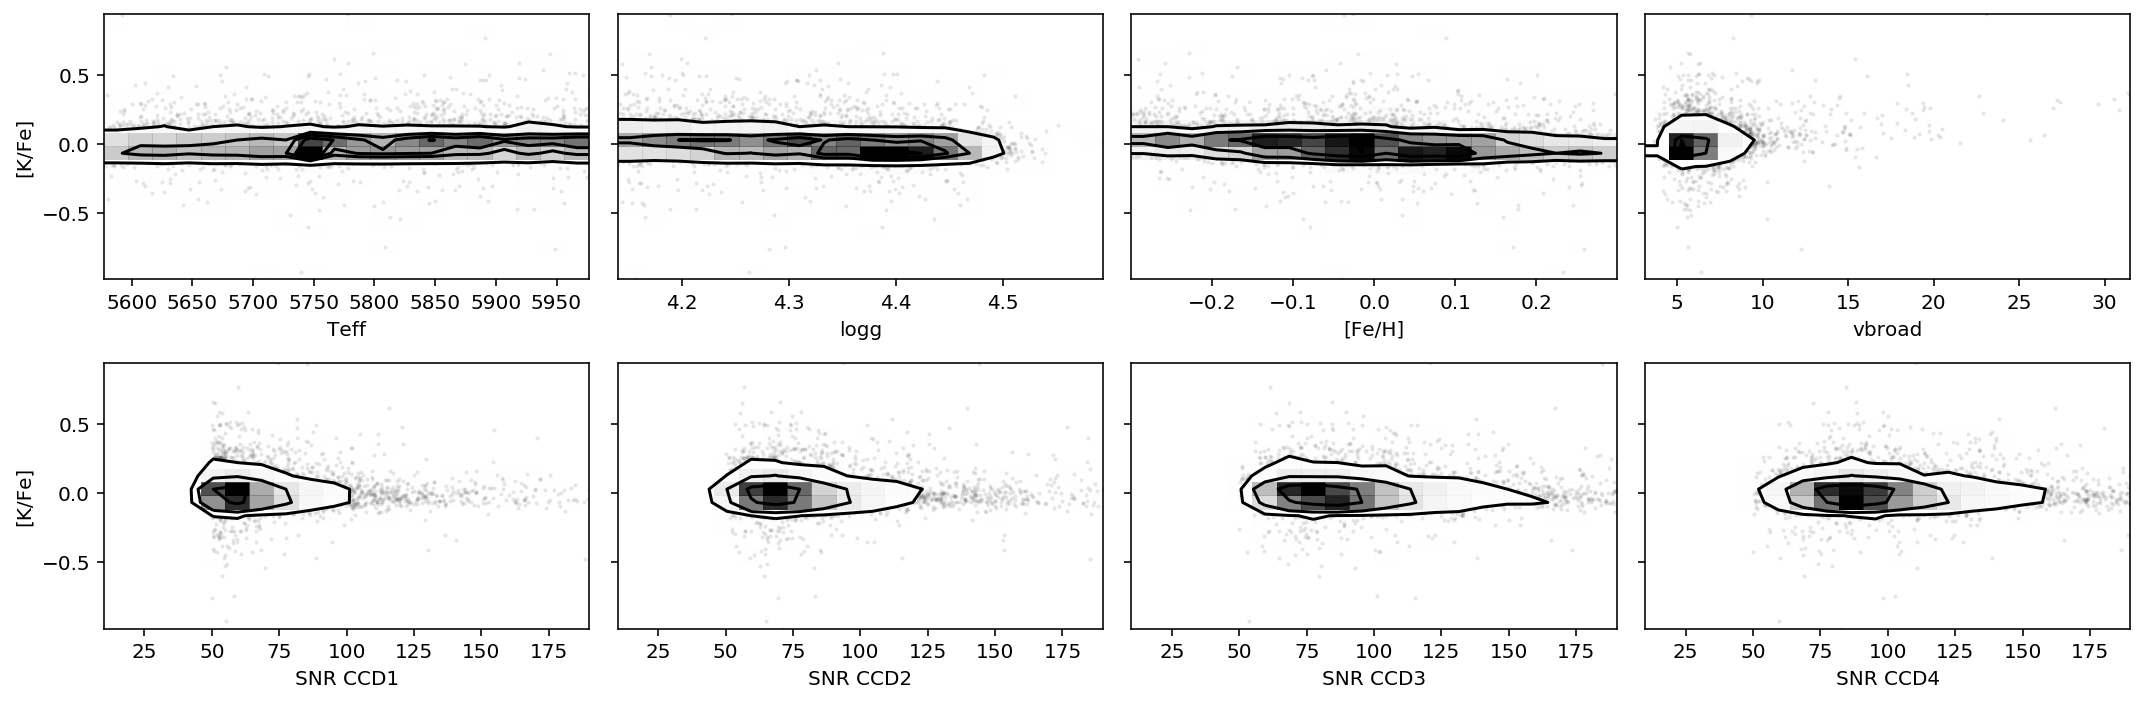

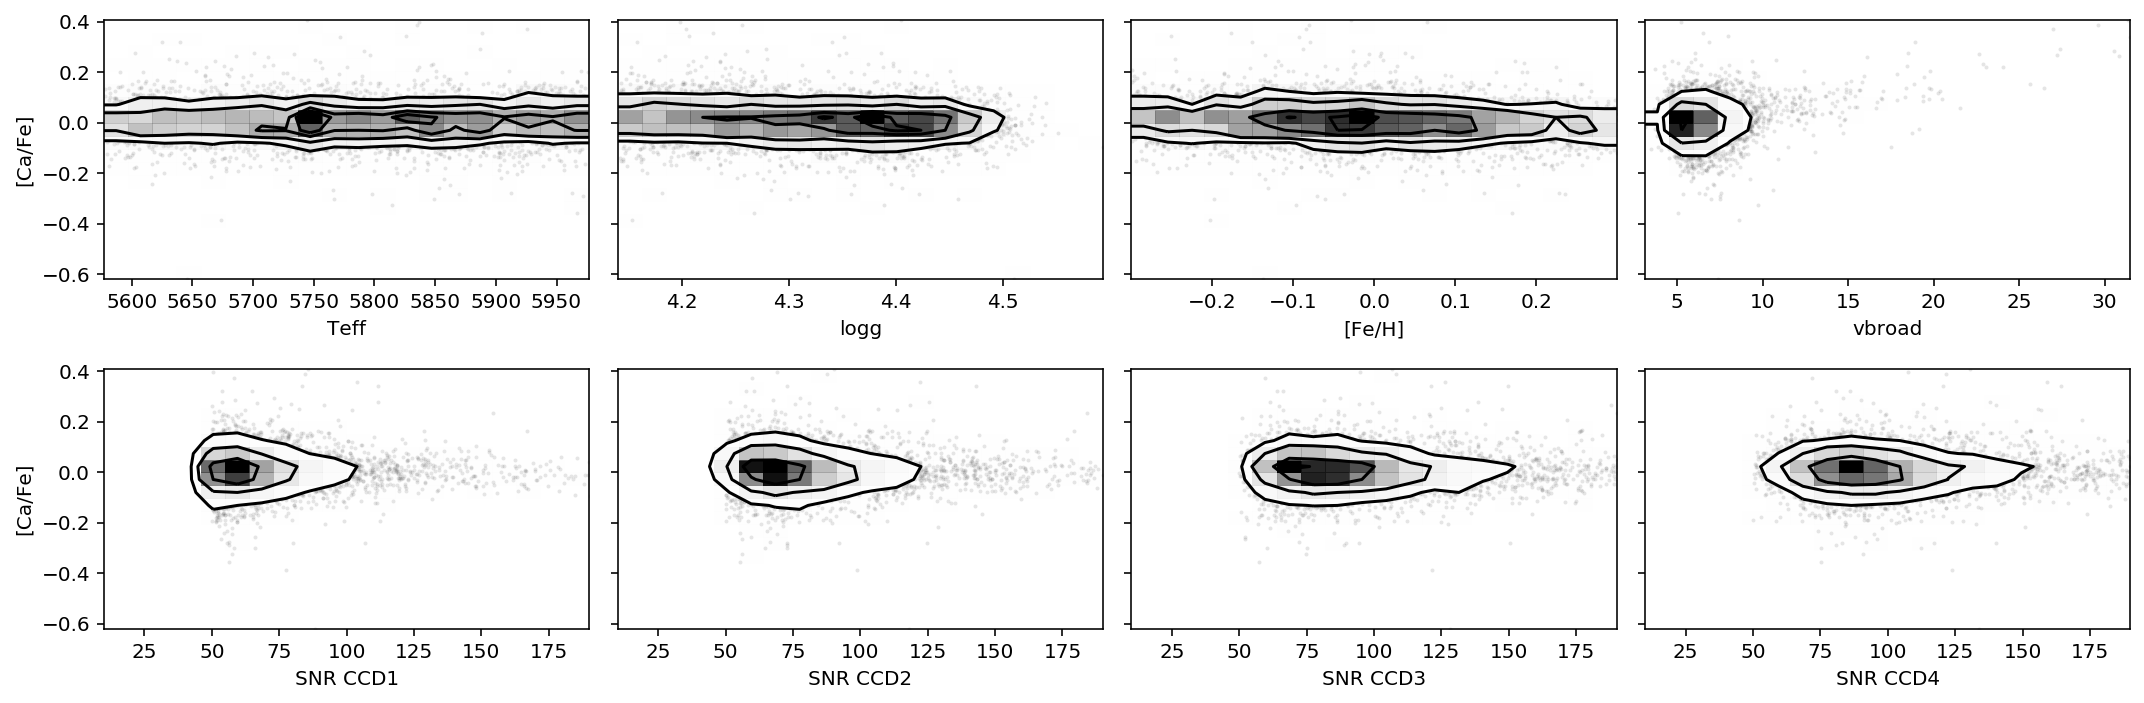

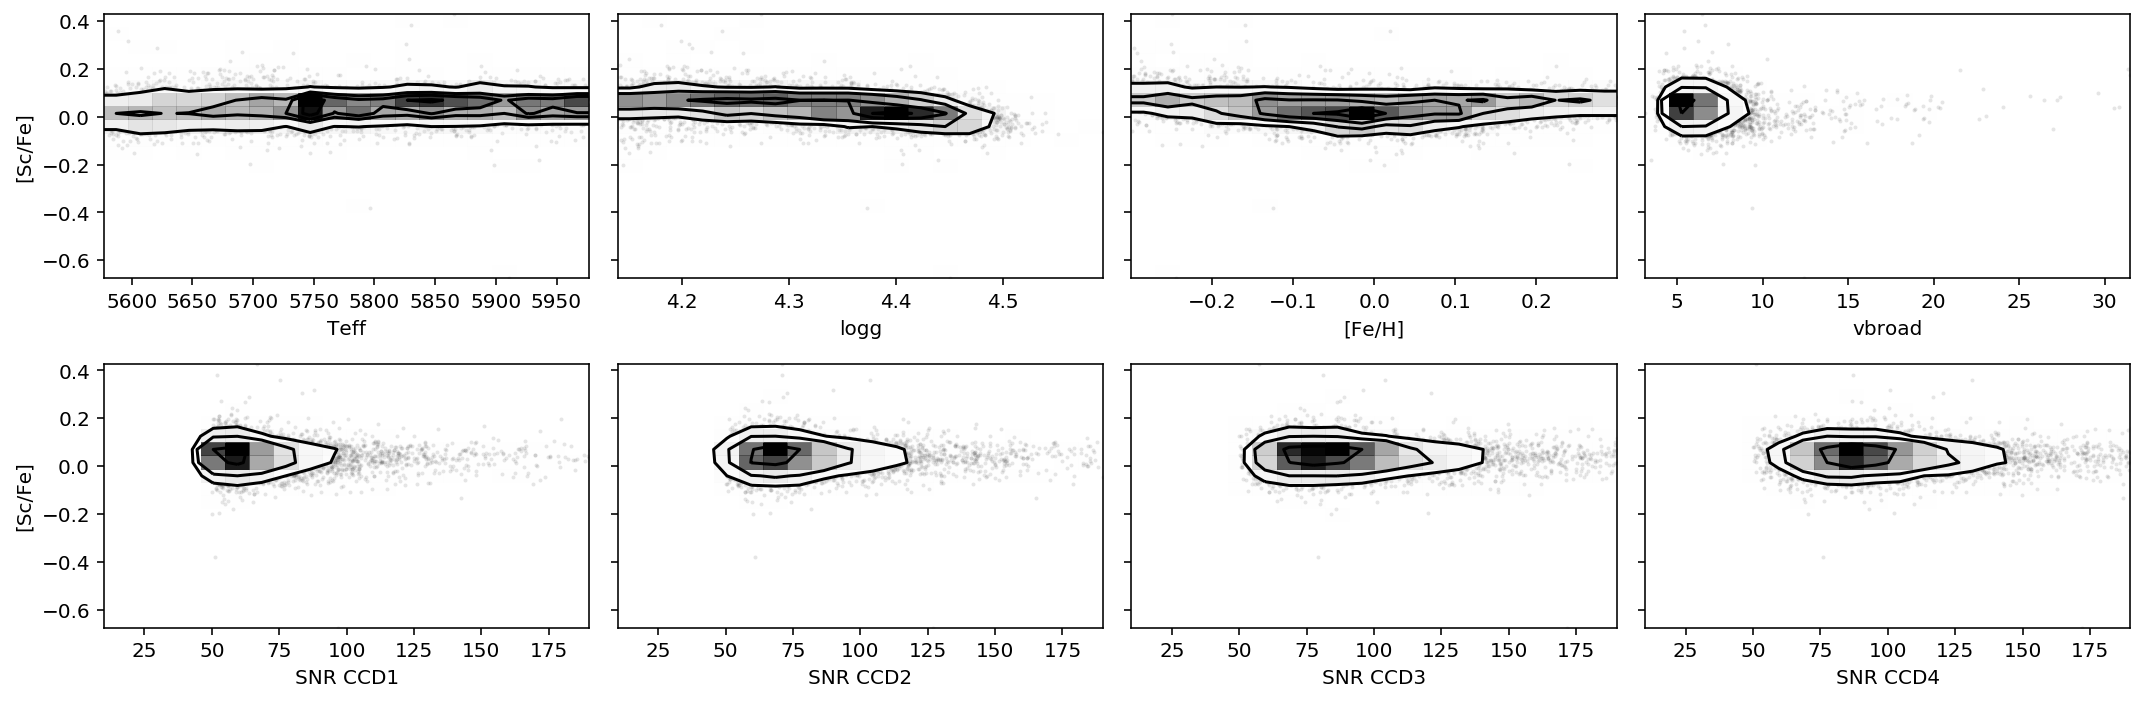

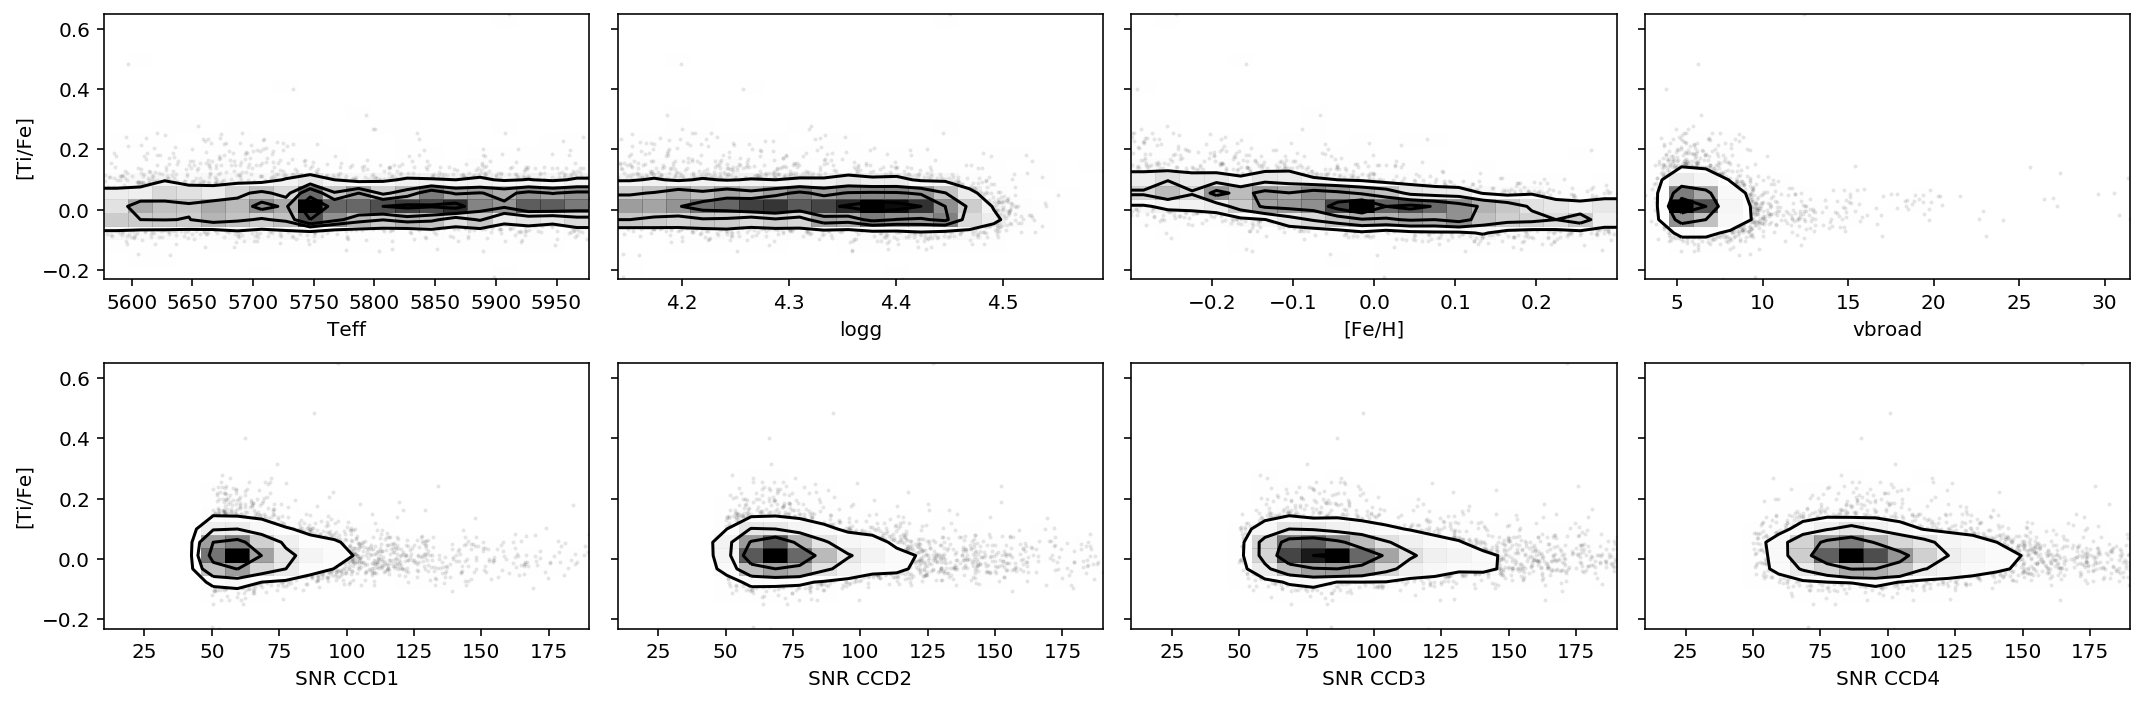

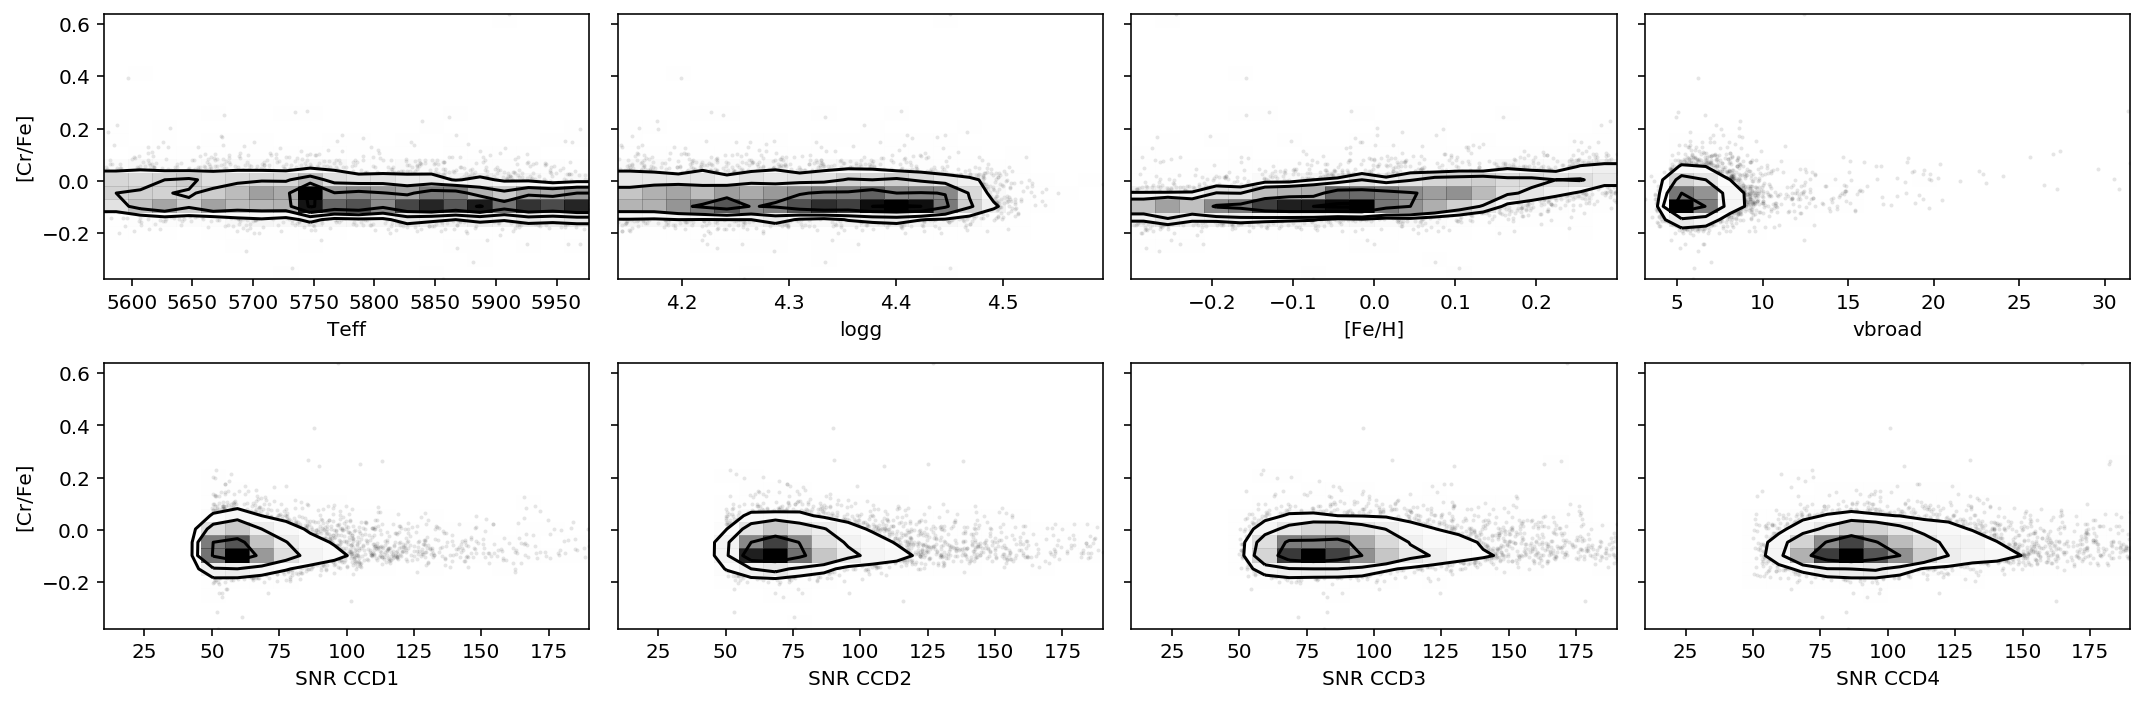

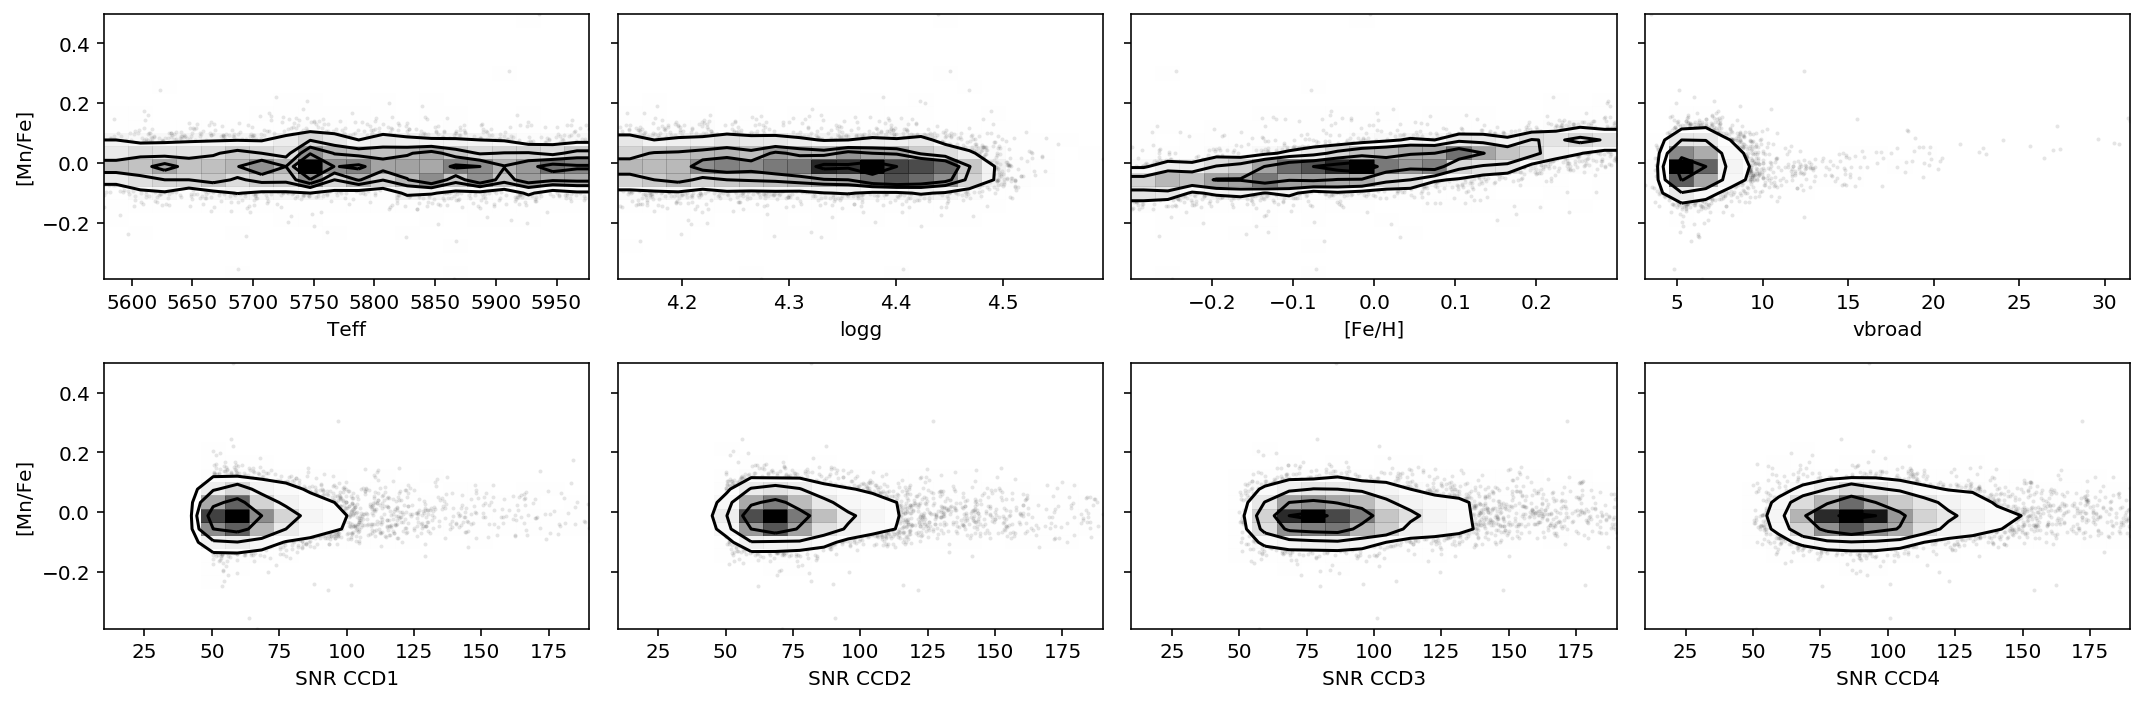

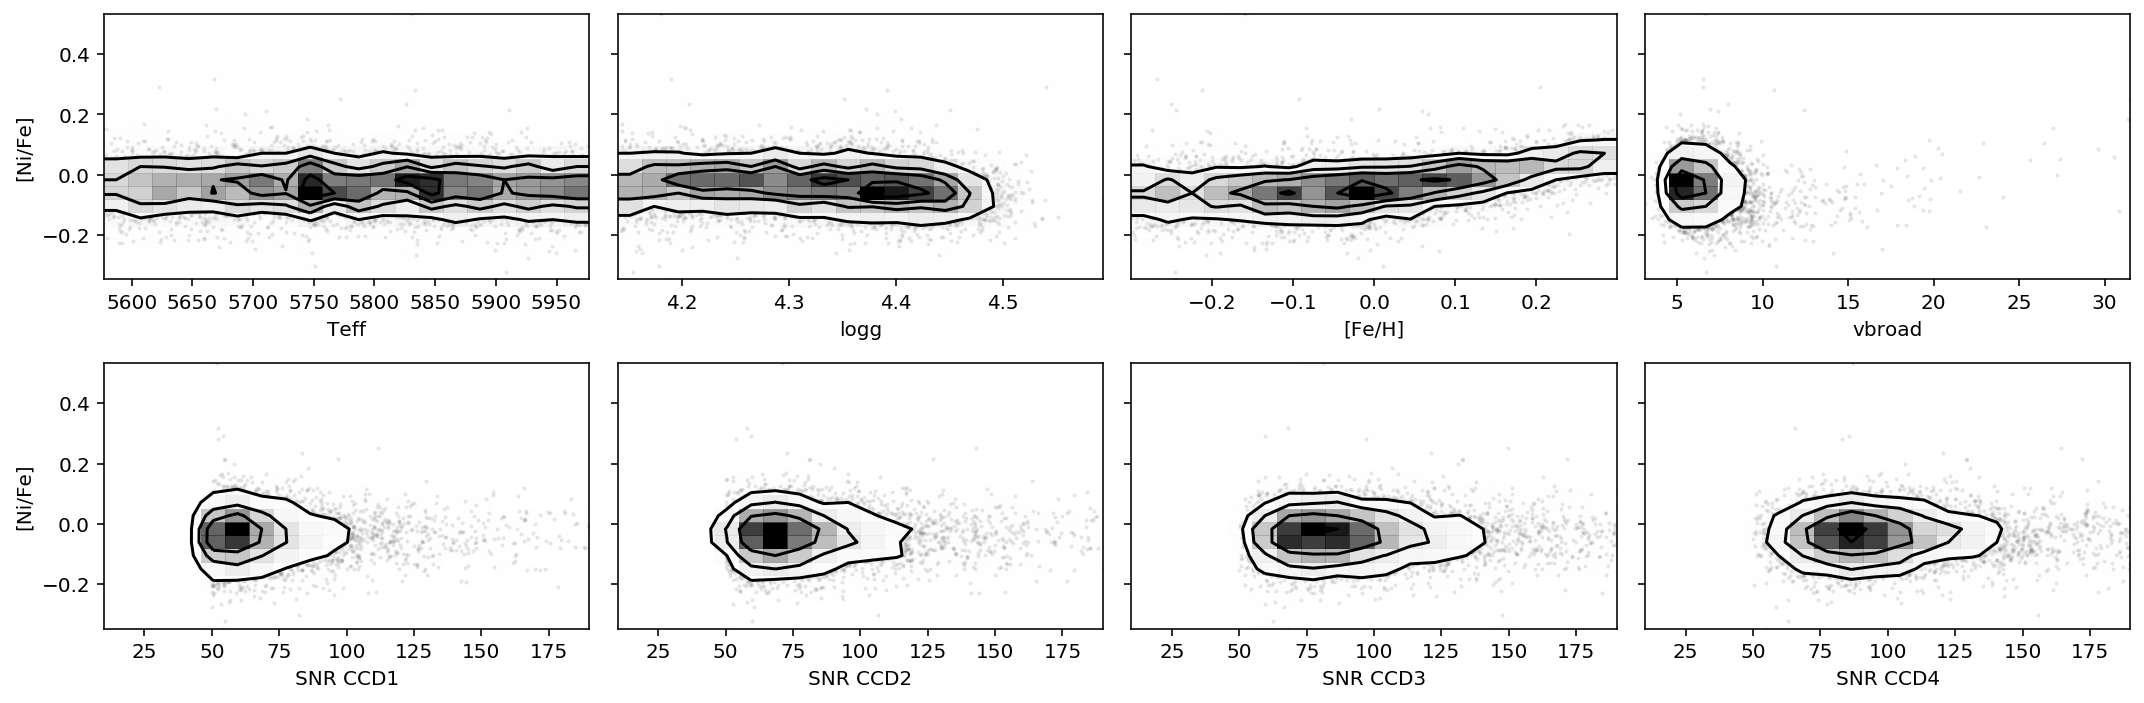

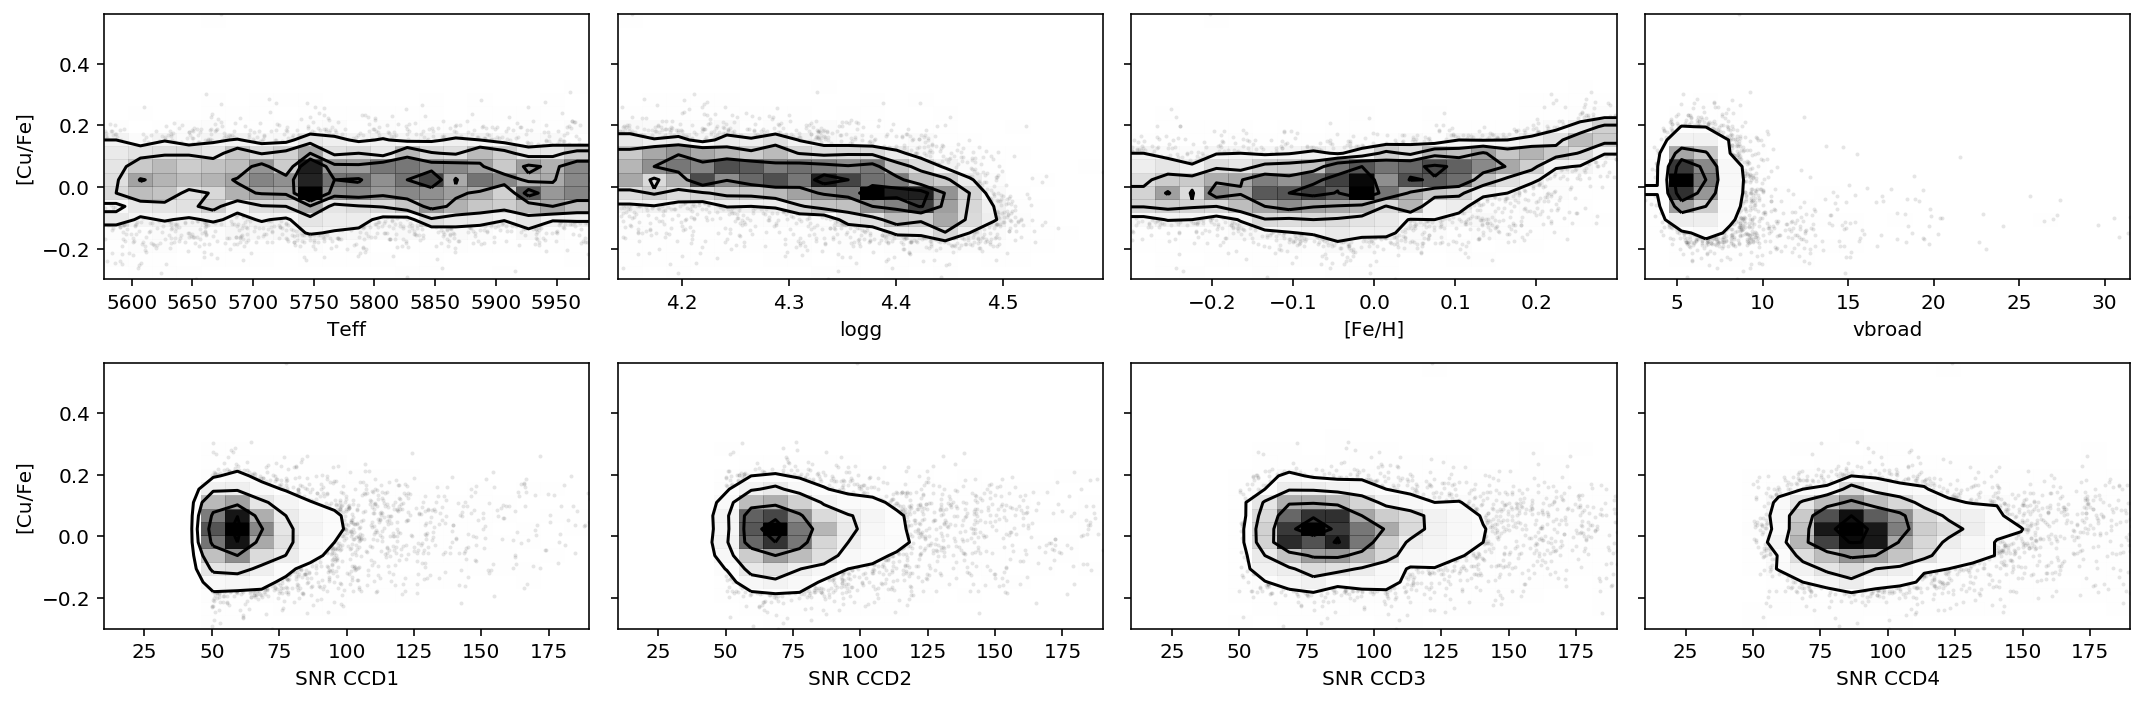

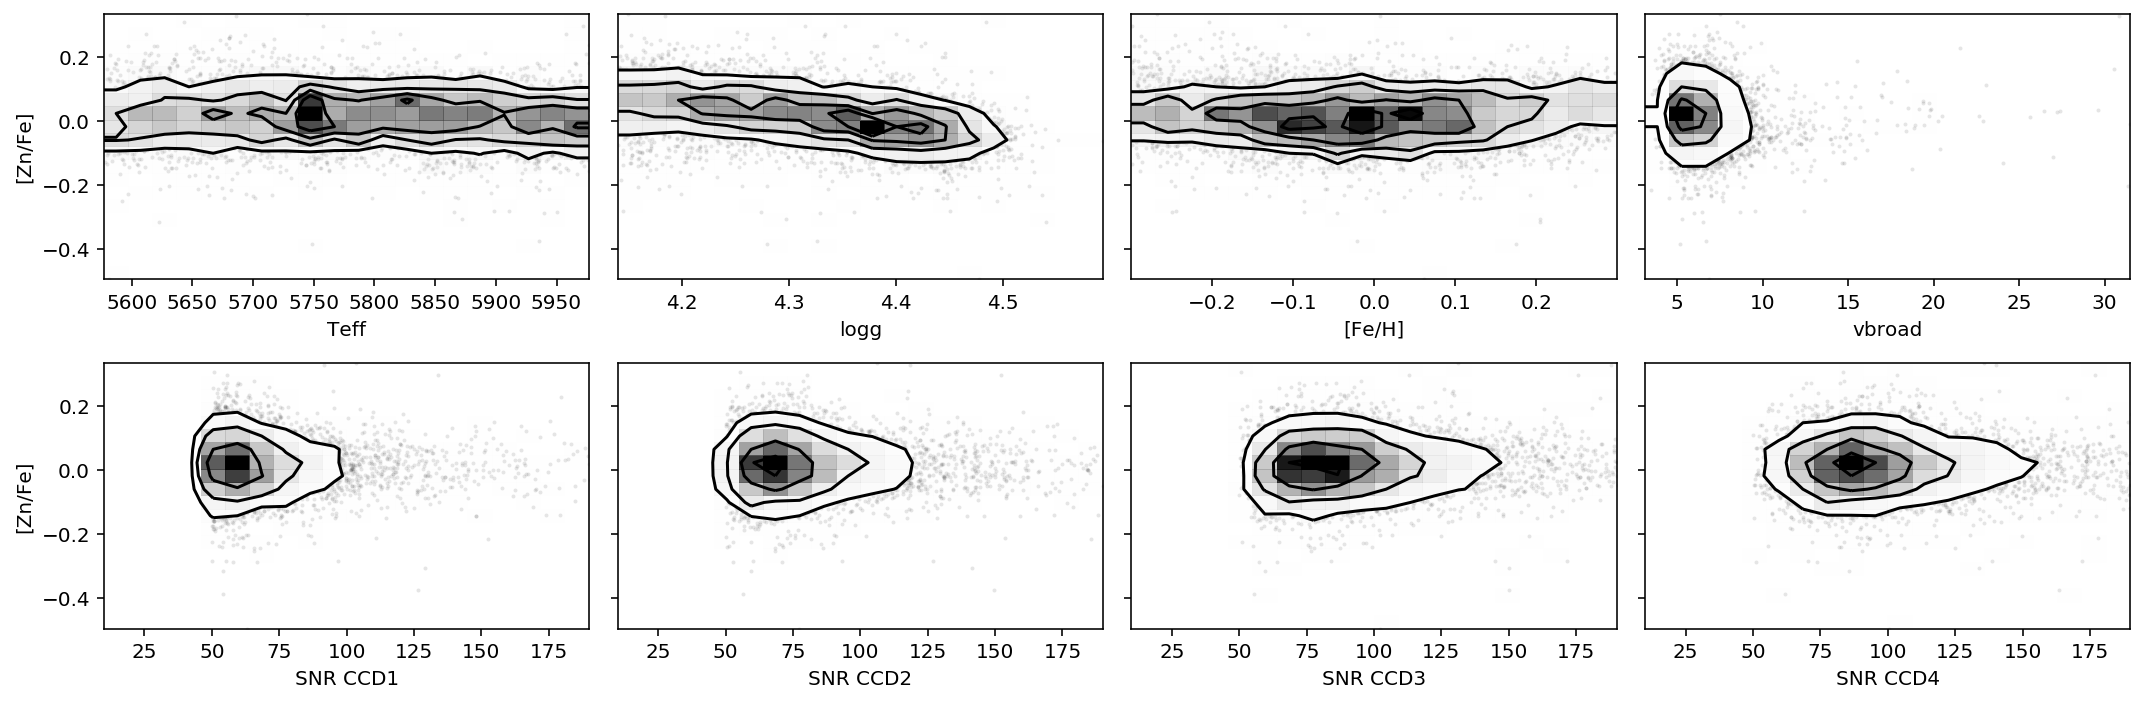

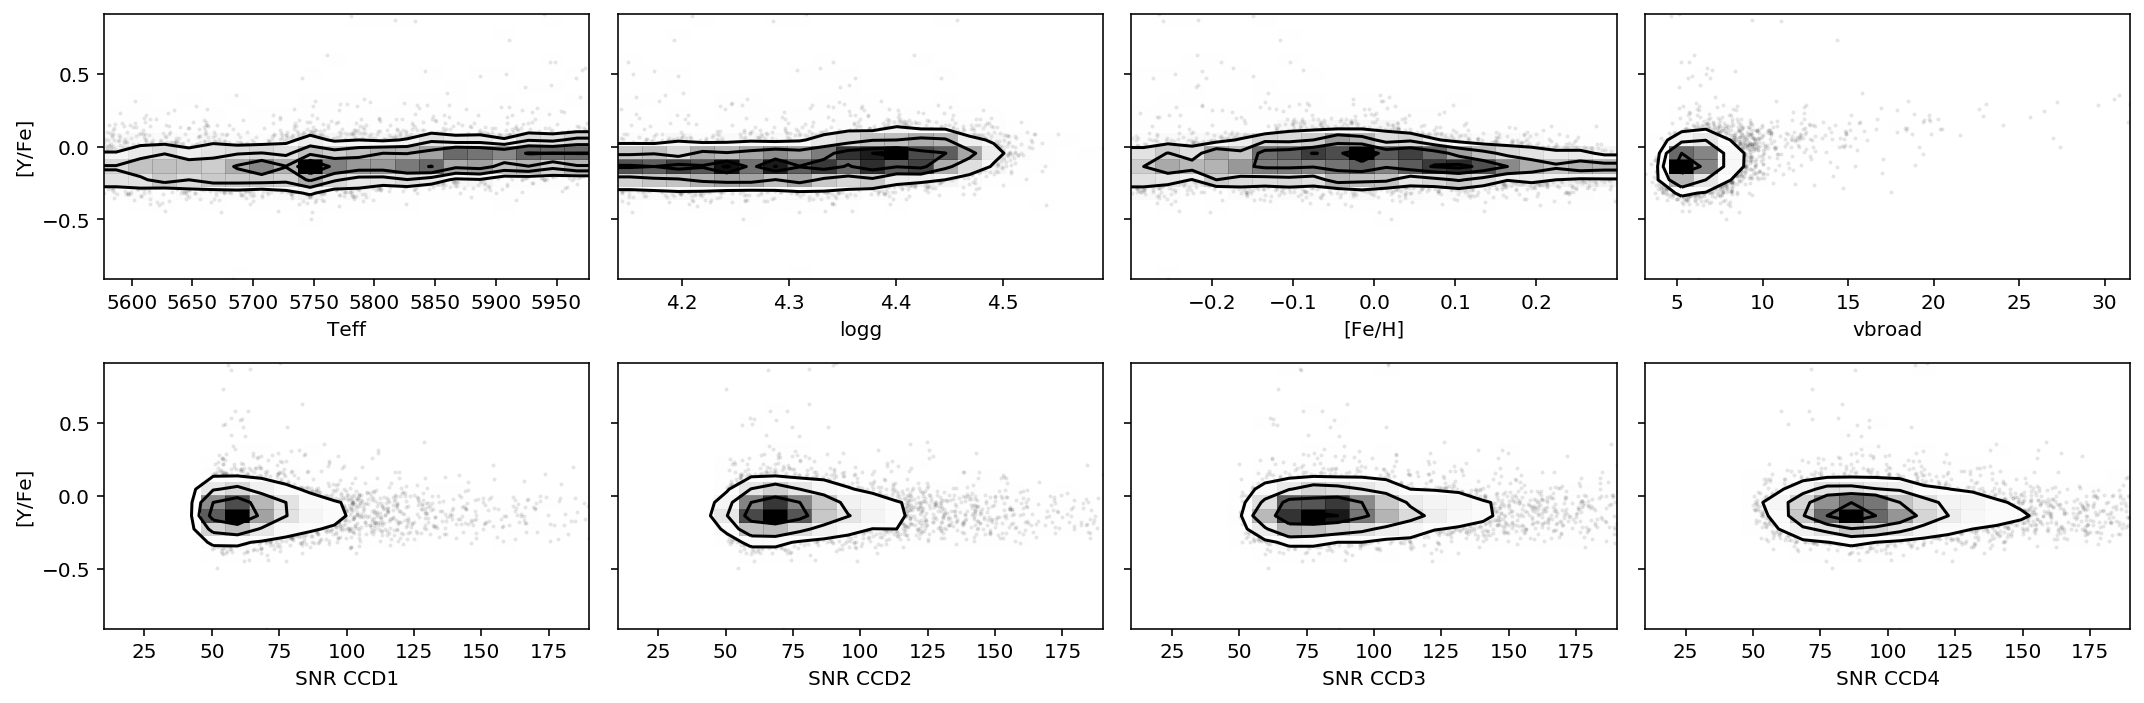

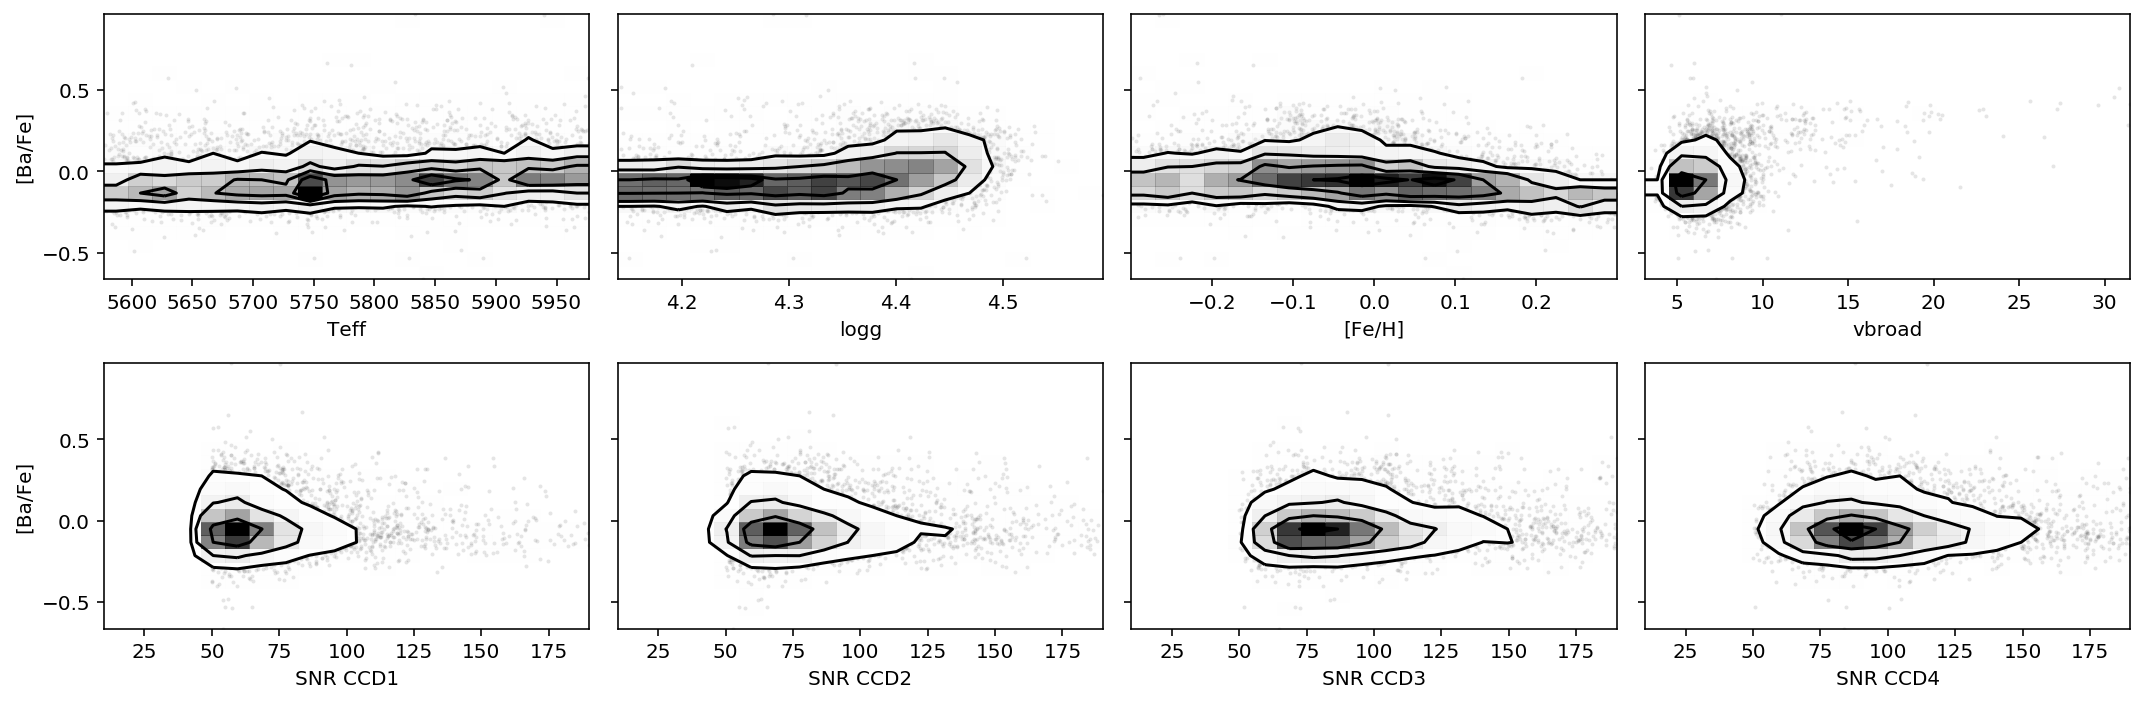

In [8]:
def diagnostic_plots_of_abundances_for_abundance_selection(best_solar_twins, abundances_to_fit):

    for element in abundances_to_fit:
        f, gs = plt.subplots(2,4,figsize=(15,5),sharey=True)
        ax = gs[0,0]
        corner.hist2d(
            data['teff'][best_solar_twins],
            data[element+'_fe'][best_solar_twins],
            ax=ax
        )
        ax.set_xlabel('Teff')
        ax.set_ylabel('['+element+'/Fe]')
        ax = gs[0,1]
        corner.hist2d(
            data['logg'][best_solar_twins],
            data[element+'_fe'][best_solar_twins],
            ax=ax
        )
        ax.set_xlabel('logg')
        ax = gs[0,2]
        corner.hist2d(
            data['fe_h'][best_solar_twins],
            data[element+'_fe'][best_solar_twins],
            ax=ax
        )
        ax.set_xlabel('[Fe/H]')
        ax = gs[0,3]
        corner.hist2d(
            data['vbroad'][best_solar_twins],
            data[element+'_fe'][best_solar_twins],
            ax=ax
        )
        ax.set_xlabel('vbroad')
        for ccd in [1,2,3,4]:
            ax = gs[1,ccd-1]
            ax.set_xlabel('SNR CCD'+str(ccd))
            if ccd==1:
                ax.set_ylabel('['+element+'/Fe]')
            corner.hist2d(
                data['snr_c'+str(ccd)+'_iraf'][best_solar_twins],
                data[element+'_fe'][best_solar_twins],
                range=[(10,190),(np.min(data[element+'_fe'][best_solar_twins]),np.max(data[element+'_fe'][best_solar_twins]))],
                ax=ax
            )
        plt.tight_layout()
        plt.show()
        plt.close()

diagnostic_plots_of_abundances_for_abundance_selection(best_solar_twins, abundances_to_fit)